In [1]:
import ray 
import ray.data
import pandas as pd
import numpy as np
import pyarrow as pa

import meerkat as mk

In [10]:
df = mk.get("imagenette")[:100]

  0%|          | 0/1 [00:00<?, ?it/s]

,path (PandasScalarColumn),noisy_labels_0 (PandasScalarColumn),noisy_labels_1 (PandasScalarColumn),noisy_labels_5 (PandasScalarColumn),noisy_labels_25 (PandasScalarColumn),noisy_labels_50 (PandasScalarColumn),is_valid (PandasScalarColumn),label_id (PandasScalarColumn),label (PandasScalarColumn),label_idx (PandasScalarColumn),split (PandasScalarColumn),img_path (PandasScalarColumn),img_id (PandasScalarColumn),index (PandasScalarColumn),img (ImageColumn),clip(img) (NumPyTensorColumn)
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False,n02979186,cassette player,482,train,train/n02979186/n02979186_9036.JPEG,n02979186_9036,0,,"np.ndarray(shape=(512,))"
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False,n02979186,cassette player,482,train,train/n02979186/n02979186_11957.JPEG,n02979186_11957,1,,"np.ndarray(shape=(512,))"
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False,n02979186,cassette player,482,train,train/n02979186/n02979186_9715.JPEG,n02979186_9715,2,,"np.ndarray(shape=(512,))"
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False,n02979186,cassette player,482,train,train/n02979186/n02979186_21736.JPEG,n02979186_21736,3,,"np.ndarray(shape=(512,))"
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False,n02979186,cassette player,482,train,train/n02979186/ILSVRC2012_val_00046953.JPEG,ILSVRC2012_val_00046953,4,,"np.ndarray(shape=(512,))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,train/n02979186/n02979186_734.JPEG,n02979186,n02979186,n02979186,n02979186,n02102040,False,n02979186,cassette player,482,train,train/n02979186/n02979186_734.JPEG,n02979186_734,95,,"np.ndarray(shape=(512,))"
96,train/n02979186/n02979186_9863.JPEG,n02979186,n02979186,n02979186,n03888257,n02102040,False,n02979186,cassette player,482,train,train/n02979186/n02979186_9863.JPEG,n02979186_9863,96,,"np.ndarray(shape=(512,))"
97,train/n02979186/n02979186_27494.JPEG,n02979186,n02979186,n02979186,n02979186,n03425413,False,n02979186,cassette player,482,train,train/n02979186/n02979186_27494.JPEG,n02979186_27494,97,,"np.ndarray(shape=(512,))"
98,train/n02979186/n02979186_11839.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False,n02979186,cassette player,482,train,train/n02979186/n02979186_11839.JPEG,n02979186_11839,98,,"np.ndarray(shape=(512,))"

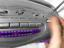
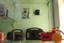
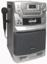
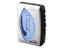
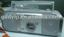
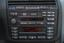
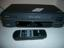
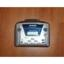
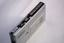
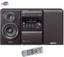

In [11]:
mk.embed(df, "img")

In [98]:
args = df["img"].data.args
ds = ray.data.from_pandas(pd.DataFrame({str(idx): arg.to_pandas() for idx, arg in enumerate(args)}))
ds = ds.repartition(1000)


def load(x):
    # print(f"loading path: {x}")
    return df["img"].data.fn(x["0"])

def operation(x):
    return x
    print(type(x))
    # print("operation")
    x = np.array(x).mean()
    return x 

pipeline = ds.window(blocks_per_window=10).map(load).map(operation)

Repartition: 100%|██████████| 1000/1000 [00:00<00:00, 1415.83it/s]
2022-12-21 13:04:09,918	INFO dataset.py:3693 -- Created DatasetPipeline with 100 windows: 0.01MiB min, 0.01MiB max, 0.01MiB mean
2022-12-21 13:04:09,918	INFO dataset.py:3703 -- Blocks per window: 10 min, 10 max, 10 mean
2022-12-21 13:04:09,919	INFO dataset.py:3725 -- ✔️  This pipeline's per-window parallelism is high enough to fully utilize the cluster.
2022-12-21 13:04:09,920	INFO dataset.py:3742 -- ✔️  This pipeline's windows likely fit in object store memory without spilling.


In [75]:
out = pipeline.take_all()

Stage 0: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


In [64]:
out = pipeline.take_all()

Stage 0: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [67]:
out = pipeline.take_all()

Stage 0: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [69]:
type(out)

list

In [81]:
ray.data.read_images(list(args[0].to_pandas()))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [86]:
paths = list("/Users/sabrieyuboglu/data/imagenette/160px/imagenette2-160/" + args[0])


In [142]:
out = ray.data.read_images(paths)

(_get_read_tasks pid=69755) 2022-12-21 14:02:25,080	WARNING file_meta_provider.py:162 -- Expanding 13394 path(s). This may be a HIGH LATENCY operation on some cloud storage services. If the specified paths all point to files and never directories, try rerunning this read with `meta_provider=FastFileMetadataProvider()`.


In [143]:
print(out)

Dataset(num_blocks=101, num_rows=13394, schema={image: ArrowVariableShapedTensorType(dtype=uint8, ndim=3)})


In [125]:
def operation(x):
    x = x["image"].mean()
    return x 
pipeline = out.window(blocks_per_window=10).map(operation)

2022-12-21 13:09:50,149	INFO dataset.py:3693 -- Created DatasetPipeline with 11 windows: 7.69MiB min, 11.01MiB max, 9.24MiB mean
2022-12-21 13:09:50,149	INFO dataset.py:3703 -- Blocks per window: 9 min, 10 max, 9 mean
2022-12-21 13:09:50,150	WARNING dataset.py:3715 -- ⚠️  This pipeline's parallelism is limited by its blocks per window to ~9 concurrent tasks per window. To maximize performance, increase the blocks per window to at least 10. This may require increasing the base dataset's parallelism and/or adjusting the windowing parameters.
2022-12-21 13:09:50,151	INFO dataset.py:3742 -- ✔️  This pipeline's windows likely fit in object store memory without spilling.


In [140]:
out.to_pandas()

Read progress: 100%|██████████| 101/101 [00:02<00:00, 40.99it/s]
/Users/sabrieyuboglu/opt/miniconda3/envs/meerkat/lib/python3.9/site-packages/ray/air/util/tensor_extensions/pandas.py:1439: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(values, copy=False)


,image
0,"[[[172, 172, 172], [172, 172, 172], [172, 172,..."
1,"[[[125, 137, 113], [136, 148, 124], [136, 148,..."
2,"[[[251, 249, 250], [251, 249, 250], [251, 249,..."
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,"[[[28, 32, 31], [28, 32, 31], [27, 33, 31], [2..."
...,...
13389,"[[[140, 141, 136], [143, 144, 139], [130, 131,..."
13390,"[[[29, 18, 22], [39, 28, 32], [47, 36, 40], [5..."
13391,"[[[61, 71, 44], [54, 64, 37], [64, 74, 49], [5..."
13392,"[[[227, 227, 225], [228, 228, 226], [228, 228,..."


In [138]:
ray.data.Dataset(
    
)

ObjectRef(8738d40215034bb1ffffffffffffffffffffffff0100000002000000)

In [149]:
data = np.zeros((100, 10, 10, 10))

pa.array(data)

ArrowInvalid: only handle 1-dimensional arrays

In [148]:
pa.Table.from_pydict({"x": pa.Tensor.from_numpy(data)})

TypeError: 'pyarrow.lib.Tensor' object is not iterable

In [150]:
from ray.data.extensions.tensor_extension import ArrowTensorArray


In [152]:
x = ArrowTensorArray.from_numpy(data)

In [159]:
pa.Table.from_pydict({"x": x})

pyarrow.Table
x: extension<arrow.py_extension_type<ArrowTensorType>>
----
x: [[[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],...,[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,

In [161]:
buffer = pa.py_buffer(data)

[
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  ...
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0
]

In [172]:

class TensorType(pa.PyExtensionType):
    def __init__(self, size):
        self.size = size
        super().__init__(pa.list_(pa.float32(), size))
    
    def __reduce__(self):
        return TensorType, (self.size,)
    


In [173]:
TensorType(1000)

TensorType(FixedSizeListType(fixed_size_list<item: float>[1000]))

In [167]:
pa.list_(pa.float32(), 3, 4)

TypeError: list_() takes at most 2 positional arguments (3 given)

In [175]:
    
arr = pa.Array.from_buffers(
    pa.from_numpy_dtype(data.dtype), len(data), [None, buffer]
)
pa.ExtensionArray.from_storage(
    TensorType(1000), arr
)

TypeError: Incompatible storage type double for extension type extension<arrow.py_extension_type<TensorType>>

In [176]:
mk.get()

In [3]:
def compute(x):
    print(x)
    return x
df["img"].defer(compute, is_batched_fn=True, batch_size=10)[0]

ObjectColumn([<PIL.Image.Im...t 0x1772D16A0>])


DeferredCell(fn=compute)

ObjectColumn([<PIL.Image.Im...t 0x12530A0D0>])
ObjectColumn([<PIL.Image.Im...t 0x1772E0580>])


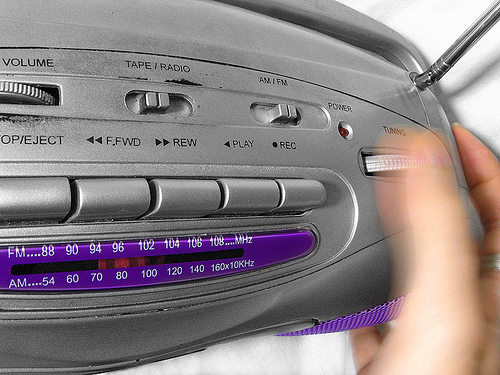

In [4]:
df["img"].defer(compute, is_batched_fn=True)[0]()

In [7]:
    print("""
    
    .. code-block:: python

        import meerkat as mk
        df = mk.DataFrame({{
            "birth_year": [1967, 1993, 2010, 1985, 2007, 1990, 1943],
            "residence": ["MA", "LA", "NY", "NY", "MA", "MA", "LA"]
        }})

        col = df["birth_year"].defer(
            lambda x: datetime.datetime.now().year - x
        )
        col()


    Args:
        {data}

    """.format(data="hello"))

KeyError: '\n        "birth_year"'